In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid
import matplotlib.pyplot as plt
import seaborn as sns
!pip install emoji
import emoji
import re
import sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import copy
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from torch import nn
from torch.optim import Adam
import torch
from transformers import AutoConfig, AutoModel, AutoTokenizer, AdamW
from transformers import DebertaV2Tokenizer
from collections import Counter


from google.colab import drive
drive.mount('/content/drive')

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#Creazione dataset, la prima colonna è il testo intero del tweet

datas = "/content/drive/MyDrive/NLP/Challenge_2024/emotion/train_text.txt"
with open(datas, 'r', encoding='utf-8') as f:
    tweets = f.readlines()

# Rimuovi eventuali spazi vuoti o newline
tweets = [tweet.strip() for tweet in tweets]

# Crea un DataFrame
data = pd.DataFrame(tweets, columns=['text'])

labels ="/content/drive/MyDrive/NLP/Challenge_2024/emotion/train_labels.txt"
with open(labels, 'r', encoding='utf-8') as f:
    labels = f.readlines()

labels2 = [int(label.strip()) for label in labels]

data.insert(1, "label", labels2)
texts = pd.DataFrame(data, columns=["text"])
data.head()

,text,label
0,“Worry is a down payment on a problem you may ...,2
1,My roommate: it's okay that we can't spell bec...,0
2,No but that's so cute. Atsu was probably shy a...,1
3,Rooneys fucking untouchable isn't he? Been fuc...,0
4,it's pretty depressing when u hit pan on ur fa...,3


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3257 entries, 0 to 3256
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3257 non-null   object
 1   label   3257 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 51.0+ KB


samples -> 3257
categories -> {0, 1, 2, 3}[4]
label
0    1400
3     855
1     708
2     294
Name: count, dtype: int64


<Axes: xlabel='label'>

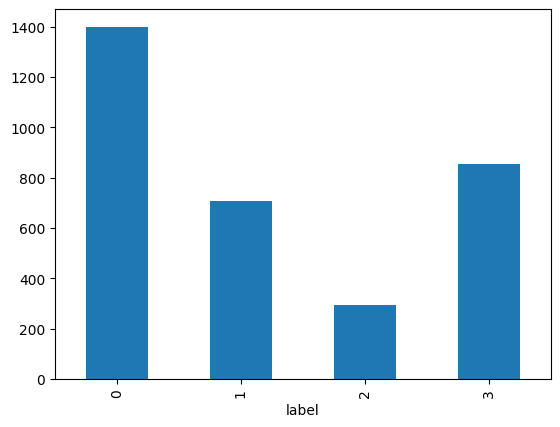

In [ ]:
#Utilizzo il bert-model-cased per il task di classificazione
#0 = Rabbia
#1 = Gioia
#2 = Ottimismo
#3 = Tristezza
print('samples -> '+str(len(data)))
labels = set(data['label'])
numLabels = len(labels)
print('categories -> '+str(labels)+'['+str(len(labels))+']')
print(data['label'].value_counts())
data.groupby(['label']).size().plot.bar()

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


    Smiley  Counttotal  Countironic  ironic_ratio
86       💕           4          4.0      1.000000
117      😍          20         20.0      1.000000
116      😋           4          4.0      1.000000
38       🍑           4          4.0      1.000000
111      😆           5          5.0      1.000000
92       💦           6          6.0      1.000000
6       ☺️           4          4.0      1.000000
23      ❤️          14         13.0      0.928571
87       💖          17         15.0      0.882353
22       ❤           7          6.0      0.857143
115      😊          11          9.0      0.818182
119      😏           4          3.0      0.750000
110      😅           8          6.0      0.750000
['💕', '😍', '😋', '🍑', '😆', '💦', '☺️', '❤️', '💖', '❤', '😊', '😏', '😅']
-----------
    Smiley  Counttotal  Countironic  ironic_ratio
150      😷           7          2.0      0.285714
170      🤔           7          2.0      0.285714
154      🙃          11          3.0      0.272727
88       💘          

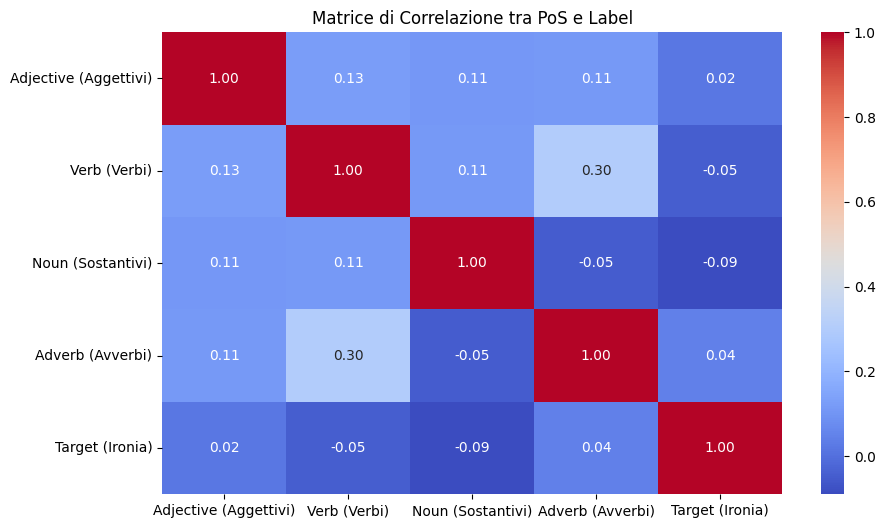

In [ ]:
#CODICE CREAZIONE DATASET DAVIDE

data['emoji_count'] = data['text'].apply(lambda text: sum(char in emoji.EMOJI_DATA.keys() for char in text))

emojidf = (texts['text'].apply(lambda text: [token.chars for token in emoji.analyze(text, join_emoji=True)
                       if isinstance(token.value, emoji.EmojiMatch)]).explode().value_counts()
                      .rename_axis('Smiley').rename('Count').reset_index())
emoji_ironic = (data[data['label'] == 1]['text'].apply(lambda text: [token.chars for token in emoji.analyze(text, join_emoji=True)
                       if isinstance(token.value, emoji.EmojiMatch)]).explode().value_counts()
                      .rename_axis('Smiley').rename('Count').reset_index())

emojidf_comparison = emojidf.merge(emoji_ironic, on='Smiley', how='outer', suffixes=('total', 'ironic')).fillna(0)
emojidf_comparison['ironic_ratio'] = emojidf_comparison['Countironic'] / emojidf_comparison['Counttotal']
emojidf_comparison = emojidf_comparison.sort_values(by='ironic_ratio', ascending=False)

emojidf_comparison = emojidf_comparison[emojidf_comparison['Counttotal']>3]
emojidf_comparison

relevant_emojis = emojidf_comparison[emojidf_comparison['Counttotal']>3]

emoji_ironic_pool = relevant_emojis[relevant_emojis['ironic_ratio']>0.6]
print(emoji_ironic_pool)
emoji_ironic_pool = emoji_ironic_pool['Smiley'].tolist()
print(emoji_ironic_pool)
print("-----------")
emoji_non_ironic_pool = relevant_emojis[relevant_emojis['ironic_ratio']<0.4]
print(emoji_non_ironic_pool)
emoji_non_ironic_pool = emoji_non_ironic_pool['Smiley'].tolist()
print(emoji_non_ironic_pool)

#data["has_ironic_emoji"] = data["text"].apply(lambda x: 1 if any(char in emoji_ironic_pool for char in x) else 0)
#data["has_non_ironic_emoji"] = data["text"].apply(lambda x: 1 if any(char in emoji_non_ironic_pool for char in x) else 0)

data['text'] = data['text'].apply(lambda text: emoji.demojize(text))

# Verifica il tokenizzatore
text = "This is a test sentence."
tokens = word_tokenize(text)
print("Tokenized:", tokens)

# Verifica il POS tagging
tags = pos_tag(tokens)
print("POS Tags:", tags)

# Funzione per contare i PoS
# Funzione per contare i PoS e restituire una lista
def extract_pos_counts(text):
    tokens = word_tokenize(text)  # Tokenizza il testo
    tagged = pos_tag(tokens)  # Tagga le parole con NLTK
    pos_counts = [0, 0, 0, 0]  # Lista per 'JJ', 'VB', 'NN', 'RB'

    for _, tag in tagged:
        if tag.startswith('JJ'):  # Aggettivi
            pos_counts[0] += 1
        elif tag.startswith('VB'):  # Verbi
            pos_counts[1] += 1
        elif tag.startswith('NN'):  # Sostantivi
            pos_counts[2] += 1
        elif tag.startswith('RB'):  # Avverbi
            pos_counts[3] += 1

    return pos_counts  # Restituisci la lista


# Applicare la funzione e creare una lista di conteggi
data['pos_counts'] = data['text'].apply(extract_pos_counts)

# Espandi la lista in colonne separate
df_pos = pd.DataFrame(data['pos_counts'].tolist(), columns=['JJ', 'VB', 'NN', 'RB'])

# Aggiungi le nuove colonne al DataFrame originale
data = pd.concat([data, df_pos], axis=1)

# Verifica se le nuove colonne sono state aggiunte correttamente
print(data[['JJ', 'VB', 'NN', 'RB']].head())

# Calcola la matrice di correlazione
correlation_matrix = data[['JJ', 'VB', 'NN', 'RB', 'label']].corr()
print(correlation_matrix)

# Espandi i risultati in colonne separate
df_pos = data['pos_counts'].apply(pd.Series)

# Evita i duplicati: Rimuovi le colonne esistenti prima di concatenare
df = data.drop(columns=['JJ', 'VB', 'NN', 'RB'], errors='ignore')  # Rimuove se esistono già
df = pd.concat([data, df_pos], axis=1)


# Calcolare la matrice di correlazione
correlation_matrix = data[['JJ', 'VB', 'NN', 'RB', 'label']].corr()

# Dizionario per spiegare le abbreviazioni
pos_labels = {
    'JJ': 'Adjective (Aggettivi)',
    'VB': 'Verb (Verbi)',
    'NN': 'Noun (Sostantivi)',
    'RB': 'Adverb (Avverbi)',
    'label': 'Target (Ironia)'
}

# Rinominare colonne e righe nella matrice di correlazione
correlation_matrix.rename(columns=pos_labels, index=pos_labels, inplace=True)

# Visualizzare la matrice di correlazione
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice di Correlazione tra PoS e Label")
plt.show()



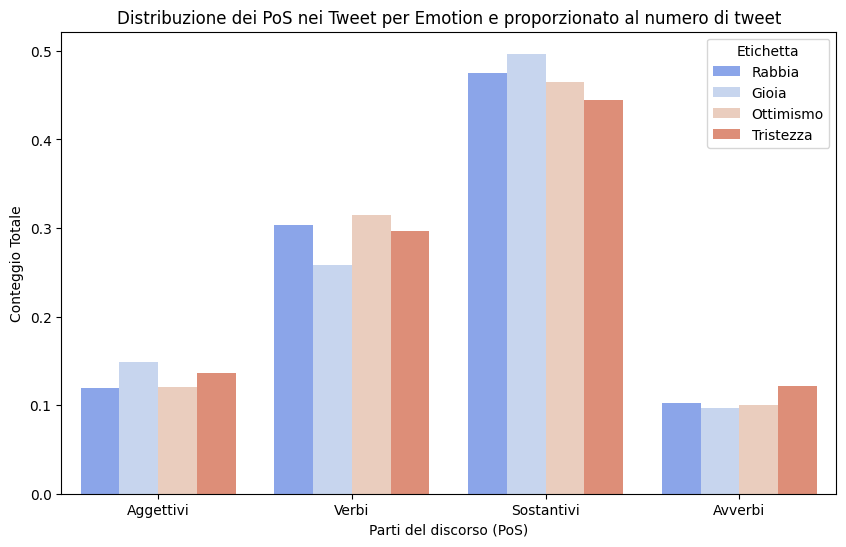

In [ ]:
#0 = Rabbia
#1 = Gioia
#2 = Ottimismo
#3 = Tristezza

# Calcolare la somma dei PoS per ciascuna classe (rabbia, gioia, ottimismo, tristezza)
pos_summary = data.groupby('label')[['JJ', 'VB', 'NN', 'RB']].sum()
# Divido per il totale di ogni PoS
pos_summary = pos_summary.div(pos_summary.sum(axis=1), axis=0)

# Rinominare le etichette per chiarezza
pos_summary.index = ['Rabbia', 'Gioia', 'Ottimismo', 'Tristezza']

# Reset dell'indice e rinomina per il metodo melt
pos_summary = pos_summary.reset_index().rename(columns={'index': 'Etichetta'})

# Trasformare il DataFrame in formato "long" con melt
pos_summary_melted = pos_summary.melt(id_vars='Etichetta', var_name='PoS', value_name='Conteggio')

# Dizionario per la leggibilità delle etichette
pos_labels_graph = {
    'JJ': 'Aggettivi',
    'VB': 'Verbi',
    'NN': 'Sostantivi',
    'RB': 'Avverbi'
}
pos_summary_melted['PoS'] = pos_summary_melted['PoS'].map(pos_labels_graph)

# Creazione del grafico
plt.figure(figsize=(10, 6))
sns.barplot(x='PoS', y='Conteggio', hue='Etichetta', data=pos_summary_melted, palette='coolwarm')

# Aggiungere titolo e etichette
plt.title("Distribuzione dei PoS nei Tweet per Emotion e proporzionato al numero di tweet")
plt.xlabel("Parti del discorso (PoS)")
plt.ylabel("Conteggio Totale")
plt.legend(title="Etichetta", loc='upper right')
plt.show()


In [ ]:
data = data.drop(columns=['JJ','VB','NN','RB'])
data

,text,label,emoji_count,pos_counts
0,“Worry is a down payment on a problem you may ...,2,0,"[1, 2, 9, 1]"
1,My roommate: it's okay that we can't spell bec...,0,0,"[3, 3, 2, 1]"
2,No but that's so cute. Atsu was probably shy a...,1,0,"[3, 3, 3, 2]"
3,Rooneys fucking untouchable isn't he? Been fuc...,0,0,"[4, 5, 4, 2]"
4,it's pretty depressing when u hit pan on ur fa...,3,0,"[4, 2, 3, 0]"
...,...,...,...,...
3252,I get discouraged because I try for 5 fucking ...,3,0,"[0, 6, 7, 0]"
3253,The @user are in contention and hosting @user ...,3,0,"[3, 3, 6, 0]"
3254,@user @user @user @user @user as a fellow UP g...,0,0,"[1, 1, 15, 0]"
3255,You have a #problem? Yes! Can you do #somethin...,0,0,"[0, 2, 3, 0]"


{'won', "it's", 'ma', 'those', 'me', 'doing', 'the', 'of', 'after', 'weren', 'a', "shan't", 'have', 'before', 'than', "hasn't", 'myself', "weren't", 'don', 'had', 'there', 'hers', "couldn't", 'above', 've', 'do', "wouldn't", 'by', 'them', "you're", 'his', 'her', 'other', 's', 'for', 'can', 'should', 'to', 'few', 'where', "mightn't", "she's", 'so', 'hasn', 'each', 'when', 'yourself', 'now', 'will', 'because', 'their', "mustn't", 'from', 'that', 'y', "aren't", "you'd", 'who', 'herself', 'with', 'on', 'they', 'hadn', 'only', 'didn', 'too', "should've", 'these', 'been', 'into', "you've", 'ours', "you'll", 'd', 'itself', 'wasn', 'its', 'over', "shouldn't", 'very', 'has', 'such', 'isn', 'themselves', 'shan', 'through', 'this', 'whom', 'and', 'yourselves', 'you', 'him', 'an', 'until', 'in', 'off', 'why', 'which', 'not', 'against', 'own', 'she', 'just', 'how', 'am', 'if', 'most', 're', "wasn't", 'all', 'be', 'any', 'your', 'what', 'about', 'it', 'or', 'during', 'again', 'no', 'did', 'i', 'were

<ipython-input-66-967ae9479f16>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(freqs), palette="viridis")


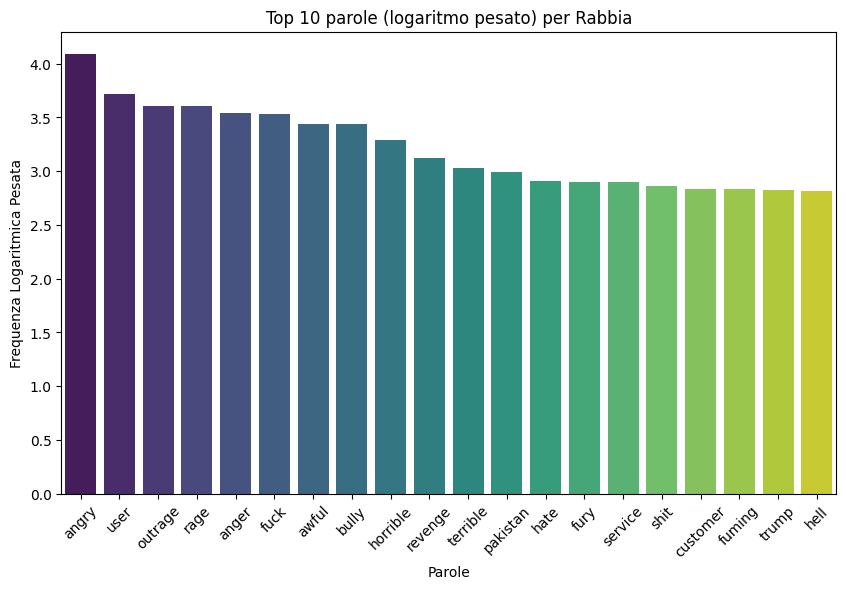

<ipython-input-66-967ae9479f16>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(freqs), palette="viridis")


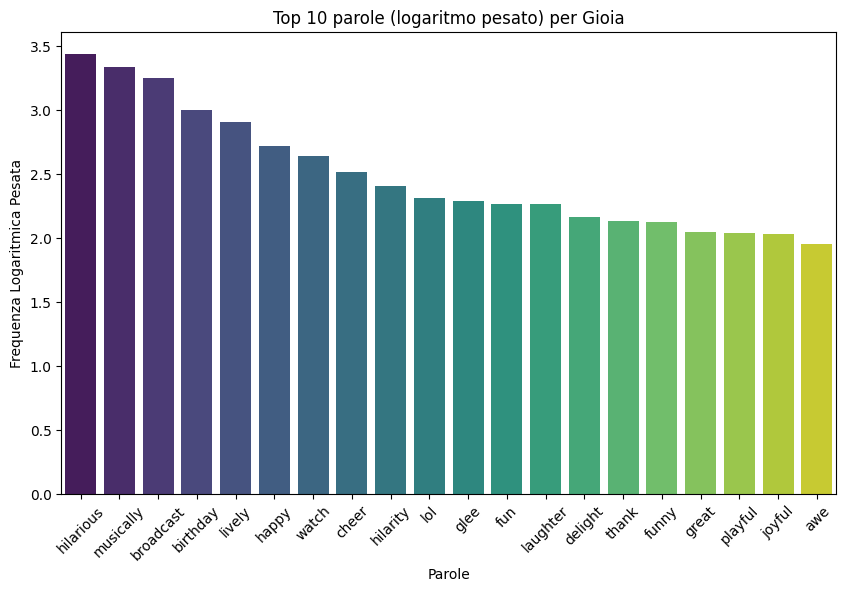

<ipython-input-66-967ae9479f16>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(freqs), palette="viridis")


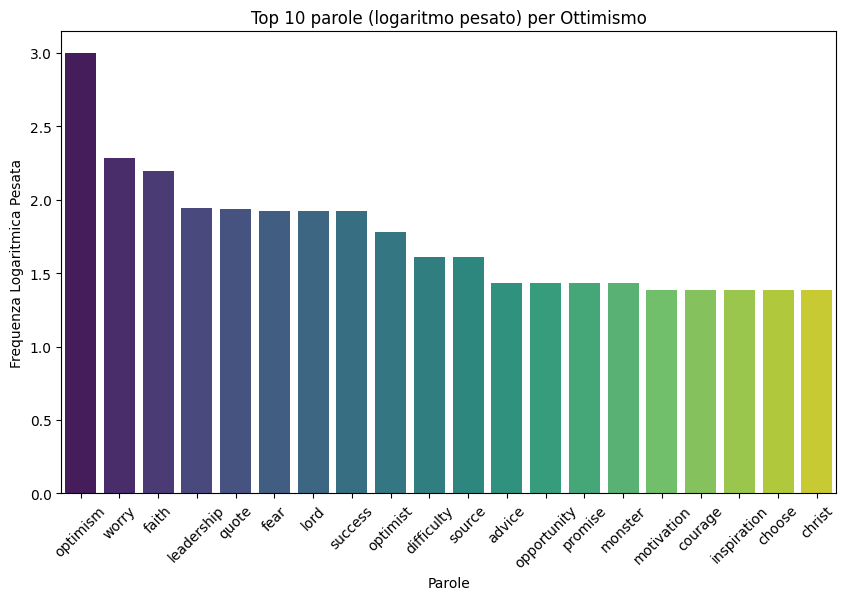

<ipython-input-66-967ae9479f16>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(freqs), palette="viridis")


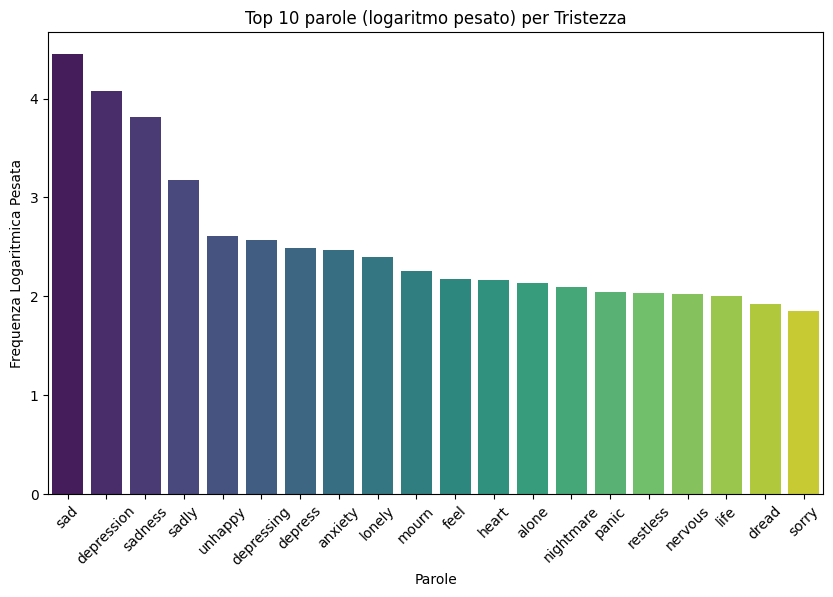

In [ ]:
stop_words = set(stopwords.words('english'))

print(stop_words)
# Dizionario per mappare i tag PoS in categorie leggibili (opzionale, se vuoi filtrare per PoS)
pos_map = {
    'JJ': 'Aggettivi',
    #'VB': 'Verbi',
    'NN': 'Sostantivi',
    'RB': 'Avverbi',
}

word_freq = {emotion: Counter() for emotion in ['Rabbia', 'Gioia', 'Ottimismo', 'Tristezza']}
total_word_count = Counter()

label_map = {0: 'Rabbia', 1: 'Gioia', 2: 'Ottimismo', 3: 'Tristezza'}


for _, row in df.iterrows():
    text = row['text']
    label = label_map[row['label']]

    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words and not word.startswith('#')]

    tagged_words = pos_tag(tokens)

    for word, pos in tagged_words:
        if pos in pos_map:
            word_freq[label][word] += 1
            total_word_count[word] += 1

normalized_word_freq = {emotion: Counter() for emotion in word_freq.keys()}

for emotion, counter in word_freq.items():
    for word, count in counter.items():
        term_freq = count / total_word_count[word]
        log_weighted_freq = term_freq * np.log(total_word_count[word] + 1)
        normalized_word_freq[emotion][word] = log_weighted_freq

for emotion, counter in normalized_word_freq.items():
    print(f"\nTop 10 parole con logaritmo pesato per {emotion}:")
    for word, freq in counter.most_common(10):
        print(f"{word}: {freq:.4f}")

for emotion, counter in normalized_word_freq.items():
    top_words = counter.most_common(20)
    words, freqs = zip(*top_words)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(words), y=list(freqs), palette="viridis")
    plt.title(f"Top 10 parole (logaritmo pesato) per {emotion}")
    plt.xlabel("Parole")
    plt.ylabel("Frequenza Logaritmica Pesata")
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
# Trova gli hashtag nel testo
hashtags = [word for word in tokens if word.startswith('#')]

# Se ci sono hashtag, stampali
if hashtags:
  print(f"Hashtag trovati nel testo: {', '.join(hashtags)}")

In [ ]:
# Inizializza le stopwords in italiano (o inglese, se il dataset è in inglese)
stop_words = set(stopwords.words('english'))  # Cambia in 'english' se il dataset è in inglese

# Dizionario per mappare i tag PoS in categorie leggibili (opzionale, se vuoi filtrare per PoS)
pos_map = {
    'JJ': 'Aggettivi', 'JJR': 'Aggettivi', 'JJS': 'Aggettivi',
    'NN': 'Sostantivi', 'NNS': 'Sostantivi', 'NNP': 'Sostantivi', 'NNPS': 'Sostantivi',
    'RB': 'Avverbi', 'RBR': 'Avverbi', 'RBS': 'Avverbi'
    # I verbi vengono esclusi qui
}

# Dizionario per salvare i conteggi delle parole per ogni emozione
word_freq = {emotion: Counter() for emotion in ['Rabbia', 'Gioia', 'Ottimismo', 'Tristezza']}
total_word_count = Counter()  # Contiene il numero totale di occorrenze di ogni parola nel dataset

# Mappa etichette numeriche -> testuali
label_map = {0: 'Rabbia', 1: 'Gioia', 2: 'Ottimismo', 3: 'Tristezza'}

# Elaborazione del dataset
for _, row in data.iterrows():
    text = row['text']  # Assumendo che la colonna con il testo si chiami 'text'
    label = label_map[row['label']]

    tokens = word_tokenize(text.lower())  # Tokenizzazione
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]  # Rimozione stopwords e segni di punteggiatura

    tagged_words = pos_tag(tokens)  # PoS tagging

    # Aggiorniamo i contatori delle parole, ma ignoriamo i verbi
    for word, pos in tagged_words:
        if pos in pos_map:  # Consideriamo solo parole mappate (ignorando i verbi)
            word_freq[label][word] += 1
            total_word_count[word] += 1  # Conta totale della parola nel dataset

# Normalizzazione e applicazione del logaritmo
normalized_word_freq = {emotion: Counter() for emotion in word_freq.keys()}

for emotion, counter in word_freq.items():
    for word, count in counter.items():
        # Calcoliamo la frequenza relativa e moltiplichiamola per il logaritmo del total count
        term_freq = count / total_word_count[word]
        log_weighted_freq = term_freq * np.log(total_word_count[word] + 1)  # +1 per evitare log(0)
        normalized_word_freq[emotion][word] = log_weighted_freq  # Frequenza logaritmica pesata

# Funzione per ottenere il vettore di punteggi per ogni tweet
def get_tweet_vector(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]  # Rimuovi stopwords

    # Inizializza il vettore dei punteggi per ogni emozione
    emotion_scores = {'Rabbia': 0, 'Gioia': 0, 'Ottimismo': 0, 'Tristezza': 0}

    # Sommiamo i punteggi per ogni parola
    for word in tokens:
        for emotion in normalized_word_freq:
            emotion_scores[emotion] += normalized_word_freq[emotion].get(word, 0)  # Aggiungi il punteggio della parola

    # Dividiamo per il numero di parole nel tweet per ottenere la media
    num_words = len(tokens)
    if num_words > 0:
        for emotion in emotion_scores:
            emotion_scores[emotion] /= num_words

    # Restituisce il vettore con i 4 punteggi
    return list(emotion_scores.values())

# Applicazione della funzione ai tweet e creazione delle feature
tweet_vectors = []
for _, row in data.iterrows():
    tweet_vector = get_tweet_vector(row['text'])
    tweet_vectors.append(tweet_vector)

# Convertilo in un DataFrame per visualizzare le feature
tweet_feature_data = pd.DataFrame(tweet_vectors, columns=['Rabbia', 'Gioia', 'Ottimismo', 'Tristezza'])
print(tweet_feature_data.head())  # Mostra le prime righe del DataFrame con i punteggi

# Ora tweet_feature_df contiene un vettore per ogni tweet con i punteggi delle emozioni


     Rabbia     Gioia  Ottimismo  Tristezza
0  0.325949  0.043967   1.098025   0.310542
1  0.783627  0.418665   0.030535   0.262310
2  0.210160  0.417779   0.073884   0.434790
3  1.085250  0.227798   0.013032   0.239959
4  0.915637  0.286400   0.097587   0.923696


In [ ]:
data['words_emotion_scores'] = tweet_feature_data.values.tolist()
data

,text,label,emoji_count,pos_counts,words_emotion_scores
0,“Worry is a down payment on a problem you may ...,2,0,"[1, 2, 9, 1]","[0.32594853980469435, 0.043966910386998334, 1...."
1,My roommate: it's okay that we can't spell bec...,0,0,"[3, 3, 2, 1]","[0.7836267915412719, 0.4186645014050449, 0.030..."
2,No but that's so cute. Atsu was probably shy a...,1,0,"[3, 3, 3, 2]","[0.21016041419506404, 0.4177788433559288, 0.07..."
3,Rooneys fucking untouchable isn't he? Been fuc...,0,0,"[4, 5, 4, 2]","[1.0852502538973707, 0.2277979439537182, 0.013..."
4,it's pretty depressing when u hit pan on ur fa...,3,0,"[4, 2, 3, 0]","[0.9156368013841698, 0.2864004636824324, 0.097..."
...,...,...,...,...,...
3252,I get discouraged because I try for 5 fucking ...,3,0,"[0, 6, 7, 0]","[0.8418929340063939, 0.38393396904174326, 0.07..."
3253,The @user are in contention and hosting @user ...,3,0,"[3, 3, 6, 0]","[1.1211675044716403, 0.4718980928583018, 0.157..."
3254,@user @user @user @user @user as a fellow UP g...,0,0,"[1, 1, 15, 0]","[2.2379468462885046, 0.8695304163708952, 0.317..."
3255,You have a #problem? Yes! Can you do #somethin...,0,0,"[0, 2, 3, 0]","[1.4346657119311477, 0.47759829009208304, 0.33..."


In [ ]:
data['word_count'] = data['text'].apply(lambda x: len(x.split())) # quantità di parole
data['text_length'] = data['text'].apply(len) # lunghezza del testo
data

,text,label,emoji_count,pos_counts,words_emotion_scores,word_count,text_length
0,“Worry is a down payment on a problem you may ...,2,0,"[1, 2, 9, 1]","[0.32594853980469435, 0.043966910386998334, 1....",17,104
1,My roommate: it's okay that we can't spell bec...,0,0,"[3, 3, 2, 1]","[0.7836267915412719, 0.4186645014050449, 0.030...",14,98
2,No but that's so cute. Atsu was probably shy a...,1,0,"[3, 3, 3, 2]","[0.21016041419506404, 0.4177788433559288, 0.07...",18,94
3,Rooneys fucking untouchable isn't he? Been fuc...,0,0,"[4, 5, 4, 2]","[1.0852502538973707, 0.2277979439537182, 0.013...",13,102
4,it's pretty depressing when u hit pan on ur fa...,3,0,"[4, 2, 3, 0]","[0.9156368013841698, 0.2864004636824324, 0.097...",11,65
...,...,...,...,...,...,...,...
3252,I get discouraged because I try for 5 fucking ...,3,0,"[0, 6, 7, 0]","[0.8418929340063939, 0.38393396904174326, 0.07...",27,136
3253,The @user are in contention and hosting @user ...,3,0,"[3, 3, 6, 0]","[1.1211675044716403, 0.4718980928583018, 0.157...",14,77
3254,@user @user @user @user @user as a fellow UP g...,0,0,"[1, 1, 15, 0]","[2.2379468462885046, 0.8695304163708952, 0.317...",18,95
3255,You have a #problem? Yes! Can you do #somethin...,0,0,"[0, 2, 3, 0]","[1.4346657119311477, 0.47759829009208304, 0.33...",14,70


In [ ]:
# Estrai gli hashtag da ogni tweet
data['hashtags'] = data['text'].apply(lambda x: re.findall(r"#\w+", x.lower()))  # Usa lower() per uniformare gli hashtag

# Espandi gli hashtag in un formato esploso per l'analisi
hashtags_exploded = data.explode('hashtags').dropna(subset=['hashtags'])

# Conta gli hashtag nei tweet per le 4 classi
#0 = Rabbia
#1 = Gioia
#2 = Ottimismo
#3 = Tristezza
hashtag_counts = (
    hashtags_exploded.groupby(['hashtags', 'label'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={0: 'count_anger', 1: 'count_joy', 2: 'count_opt', 3: 'count_sad'})
)

# Calcola il totale e la probabilità di emotion per ogni hashtag
hashtag_counts['count_total'] = hashtag_counts['count_anger'] + hashtag_counts['count_joy'] + hashtag_counts['count_opt'] + hashtag_counts['count_sad']
hashtag_counts['anger_ratio'] = hashtag_counts['count_anger'] / hashtag_counts['count_total']
hashtag_counts['joy_ratio'] = hashtag_counts['count_joy'] / hashtag_counts['count_total']
hashtag_counts['opt_ratio'] = hashtag_counts['count_opt'] / hashtag_counts['count_total']
hashtag_counts['sad_ratio'] = hashtag_counts['count_sad'] / hashtag_counts['count_total']

# Ordina per probabilità di ironia (opzionale)
hashtag_counts = hashtag_counts.sort_values(by='count_total', ascending=False)

# Mostra i risultati
print(hashtag_counts)

# Filtra gli hashtag più significativi (opzionale)
significant_hashtags = hashtag_counts[hashtag_counts['count_total'] > 3]  # Ad esempio, solo quelli con >5 occorrenze
print(significant_hashtags)

label        count_anger  count_joy  count_opt  count_sad  count_total  \
hashtags                                                                 
#sad                   1          0          0         49           50   
#depression            0          0          1         41           42   
#sadness               0          0          0         38           38   
#terrorism            22          0          7          5           34   
#fear                  8          1         14         10           33   
...                  ...        ...        ...        ...          ...   
#アニメ                   1          0          0          0            1   
#1                     1          0          0          0            1   
#10golds24             0          0          1          0            1   
#12years               0          1          0          0            1   
#2                     0          0          1          0            1   

label        anger_ratio  joy_ratio  


Top 10 hashtag con logaritmo pesato per Rabbia:
#fuming: 3.4340
#rage: 3.2958
#angry: 3.2780
#awful: 3.2421
#anger: 3.1278
#horrible: 2.9974
#terrible: 2.9155
#shocking: 2.8863
#bully: 2.6495
#outrage: 2.6391

Top 10 hashtag con logaritmo pesato per Gioia:
#musically: 3.3322
#hilarious: 3.2189
#lively: 2.7081
#blues: 2.4629
#happy: 2.2590
#funny: 2.1972
#smile: 2.1375
#cheer: 1.9459
#lol: 1.8270
#rock: 1.7918

Top 10 hashtag con logaritmo pesato per Ottimismo:
#optimism: 2.3979
#quote: 2.3512
#faith: 2.0794
#leadership: 1.7918
#monster: 1.6094
#fear: 1.4960
#life: 1.4387
#relentless: 1.4334
#motivation: 1.3863
#promise: 1.3863

Top 10 hashtag con logaritmo pesato per Tristezza:
#sad: 3.8532
#depression: 3.6716
#sadness: 3.6636
#lost: 2.8165
#depressing: 2.7726
#anxiety: 2.7151
#mhchat: 2.4849
#nightmare: 2.4683
#unhappy: 1.9459
#restless: 1.9226


<ipython-input-72-369b2ec4b556>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(hashtags), y=list(freqs), palette="viridis")


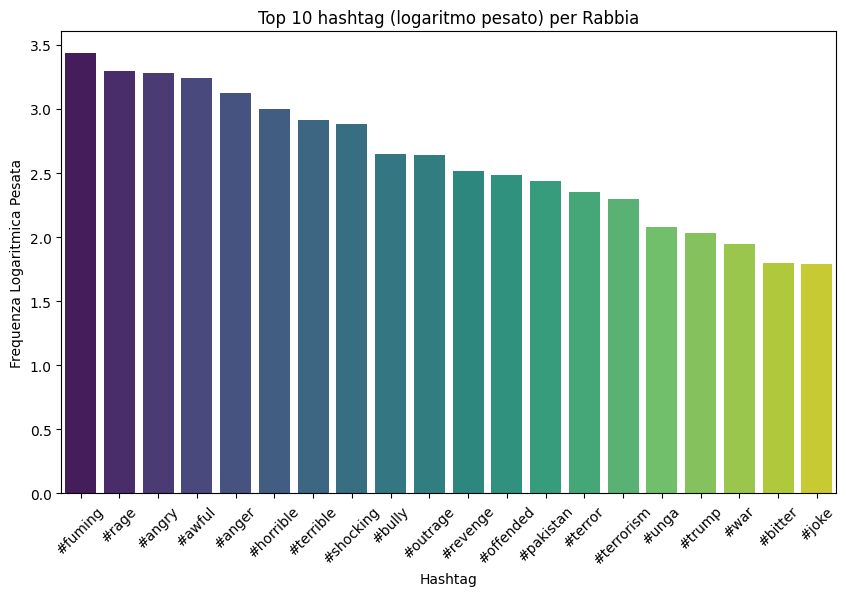

<ipython-input-72-369b2ec4b556>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(hashtags), y=list(freqs), palette="viridis")


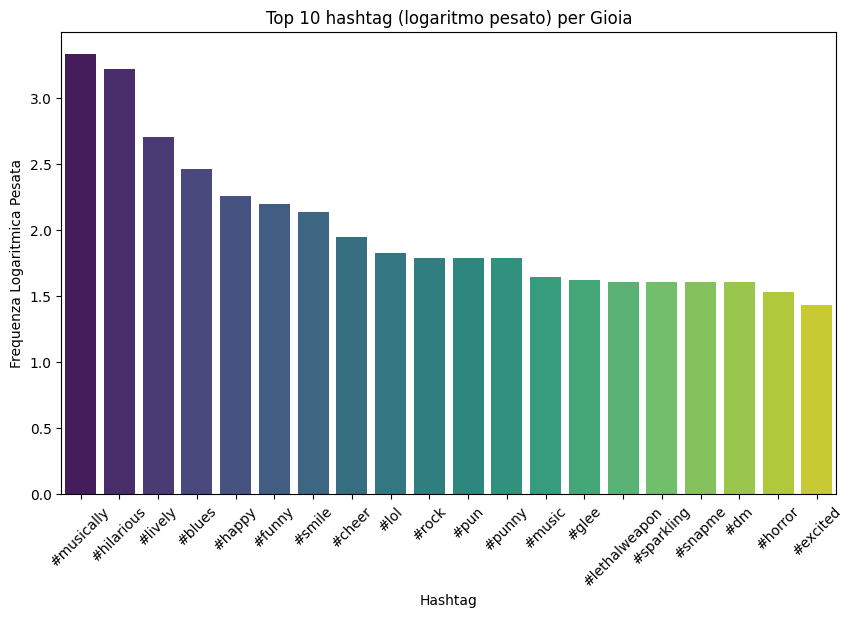

<ipython-input-72-369b2ec4b556>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(hashtags), y=list(freqs), palette="viridis")


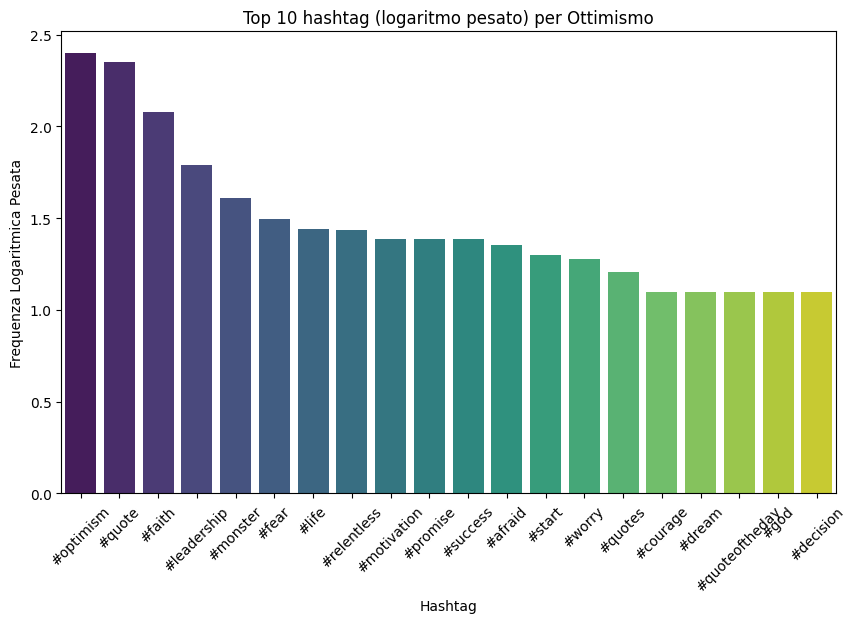

<ipython-input-72-369b2ec4b556>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(hashtags), y=list(freqs), palette="viridis")


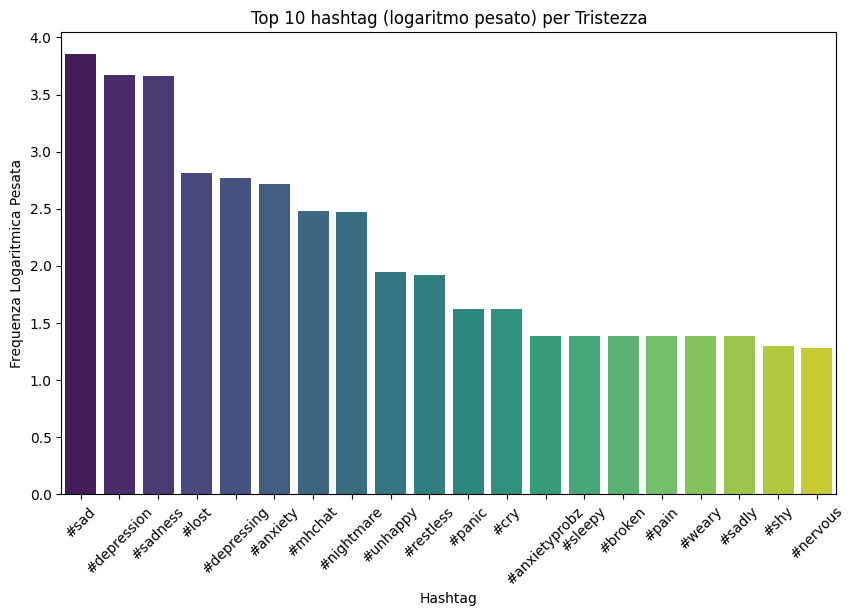

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# Dizionario per salvare i conteggi degli hashtag per ogni emozione
hashtag_freq = {emotion: Counter() for emotion in ['Rabbia', 'Gioia', 'Ottimismo', 'Tristezza']}
total_hashtag_count = Counter()  # Contiene il numero totale di occorrenze di ogni hashtag nel dataset

# Mappa etichette numeriche -> testuali
label_map = {0: 'Rabbia', 1: 'Gioia', 2: 'Ottimismo', 3: 'Tristezza'}

# Elaborazione del dataset (assumiamo che ci sia una colonna 'hashtags' che contiene gli hashtag)
for _, row in data.iterrows():
    hashtags = row['hashtags']  # Assumiamo che la colonna con gli hashtag si chiami 'hashtags'
    label = label_map[row['label']]

    for hashtag in hashtags:  # Contiamo gli hashtag per ciascuna emozione
        hashtag_freq[label][hashtag] += 1
        total_hashtag_count[hashtag] += 1  # Conta totale dell'hashtag nel dataset

# Normalizzazione e applicazione del logaritmo
normalized_hashtag_freq = {emotion: Counter() for emotion in hashtag_freq.keys()}

for emotion, counter in hashtag_freq.items():
    for hashtag, count in counter.items():
        # Calcoliamo la frequenza relativa e moltiplichiamola per il logaritmo del total count
        term_freq = count / total_hashtag_count[hashtag]
        log_weighted_freq = term_freq * np.log(total_hashtag_count[hashtag] + 1)  # +1 per evitare log(0)
        normalized_hashtag_freq[emotion][hashtag] = log_weighted_freq  # Frequenza logaritmica pesata

# Stampa delle 10 parole più frequenti per ogni emozione dopo la normalizzazione logaritmica
for emotion, counter in normalized_hashtag_freq.items():
    print(f"\nTop 10 hashtag con logaritmo pesato per {emotion}:")
    for hashtag, freq in counter.most_common(10):
        print(f"{hashtag}: {freq:.4f}")

# Creazione dei grafici
for emotion, counter in normalized_hashtag_freq.items():
    top_hashtags = counter.most_common(20)
    hashtags, freqs = zip(*top_hashtags)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(hashtags), y=list(freqs), palette="viridis")
    plt.title(f"Top 10 hashtag (logaritmo pesato) per {emotion}")
    plt.xlabel("Hashtag")
    plt.ylabel("Frequenza Logaritmica Pesata")
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
# Dizionario per salvare i conteggi degli hashtag per ogni emozione
hashtag_freq = {emotion: Counter() for emotion in ['Rabbia', 'Gioia', 'Ottimismo', 'Tristezza']}
total_hashtag_count = Counter()  # Contiene il numero totale di occorrenze di ogni hashtag nel dataset

# Elaborazione degli hashtag nel dataset
for _, row in data.iterrows():
    hashtags = row['hashtags']  # Assumiamo che la colonna con gli hashtag si chiami 'hashtags'
    label = label_map[row['label']]

    for hashtag in hashtags:  # Contiamo gli hashtag per ciascuna emozione
        hashtag_freq[label][hashtag] += 1
        total_hashtag_count[hashtag] += 1  # Conta totale dell'hashtag nel dataset

# Normalizzazione e applicazione del logaritmo
normalized_hashtag_freq = {emotion: Counter() for emotion in hashtag_freq.keys()}

for emotion, counter in hashtag_freq.items():
    for hashtag, count in counter.items():
        # Calcoliamo la frequenza relativa e moltiplichiamola per il logaritmo del total count
        term_freq = count / total_hashtag_count[hashtag]
        log_weighted_freq = term_freq * np.log(total_hashtag_count[hashtag] + 1)  # +1 per evitare log(0)
        normalized_hashtag_freq[emotion][hashtag] = log_weighted_freq  # Frequenza logaritmica pesata

# Funzione per ottenere il vettore dei punteggi per ogni tweet basato sugli hashtag
def get_hashtag_vector(hashtags):
    # Inizializza il vettore dei punteggi per ogni emozione
    emotion_scores = {'Rabbia': 0, 'Gioia': 0, 'Ottimismo': 0, 'Tristezza': 0}

    # Sommiamo i punteggi per ogni hashtag
    for hashtag in hashtags:
        for emotion in normalized_hashtag_freq:
            emotion_scores[emotion] += normalized_hashtag_freq[emotion].get(hashtag, 0)  # Aggiungi il punteggio dell'hashtag

    # Restituisce il vettore con i 4 punteggi come lista
    return list(emotion_scores.values())

# Applicazione della funzione agli hashtag e creazione della colonna con i vettori
data['hastag_emotion_scores'] = data['hashtags'].apply(get_hashtag_vector)




In [ ]:
data

,text,label,emoji_count,pos_counts,words_emotion_scores,word_count,text_length,hashtags,hastag_emotion_scores
0,“Worry is a down payment on a problem you may ...,2,0,"[1, 2, 9, 1]","[0.32594853980469435, 0.043966910386998334, 1....",17,104,"[#motivation, #leadership, #worry]","[0.25584278811044947, 0, 4.457267770900193, 0...."
1,My roommate: it's okay that we can't spell bec...,0,0,"[3, 3, 2, 1]","[0.7836267915412719, 0.4186645014050449, 0.030...",14,98,"[#terrible, #firstworldprobs]","[3.4648541411840386, 0.8028320571036185, 0, 0...."
2,No but that's so cute. Atsu was probably shy a...,1,0,"[3, 3, 3, 2]","[0.21016041419506404, 0.4177788433559288, 0.07...",18,94,[],"[0, 0, 0, 0]"
3,Rooneys fucking untouchable isn't he? Been fuc...,0,0,"[4, 5, 4, 2]","[1.0852502538973707, 0.2277979439537182, 0.013...",13,102,[],"[0, 0, 0, 0]"
4,it's pretty depressing when u hit pan on ur fa...,3,0,"[4, 2, 3, 0]","[0.9156368013841698, 0.2864004636824324, 0.097...",11,65,[],"[0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...
3252,I get discouraged because I try for 5 fucking ...,3,0,"[0, 6, 7, 0]","[0.8418929340063939, 0.38393396904174326, 0.07...",27,136,[],"[0, 0, 0, 0]"
3253,The @user are in contention and hosting @user ...,3,0,"[3, 3, 6, 0]","[1.1211675044716403, 0.4718980928583018, 0.157...",14,77,[#sad],"[0.07863651265448651, 0, 0, 3.853189120069839]"
3254,@user @user @user @user @user as a fellow UP g...,0,0,"[1, 1, 15, 0]","[2.2379468462885046, 0.8695304163708952, 0.317...",18,95,[],"[0, 0, 0, 0]"
3255,You have a #problem? Yes! Can you do #somethin...,0,0,"[0, 2, 3, 0]","[1.4346657119311477, 0.47759829009208304, 0.33...",14,70,"[#problem, #something]","[1.0114042647073516, 0, 1.4735023850806486, 0]"


In [ ]:
enc = OrdinalEncoder()
labels = data["label"]
data2 = data.drop("text", axis=1)
data2.drop("hashtags", axis=1, inplace=True)

In [ ]:
data2['JJ'] = [x[0] for x in data['pos_counts']]
data2['VB'] = [x[1] for x in data['pos_counts']]
data2['NN'] = [x[2] for x in data['pos_counts']]
data2['RB'] = [x[3] for x in data['pos_counts']]
data2['word_rabbia_scores'] = [x[0] for x in data['words_emotion_scores']]
data2['word_gioia_scores'] = [x[1] for x in data['words_emotion_scores']]
data2['word_optym_scores'] = [x[2] for x in data['words_emotion_scores']]
data2['word_tristezza_scores'] = [x[3] for x in data['words_emotion_scores']]
data2['hastag_rabbia_scores'] = [x[0] for x in data['hastag_emotion_scores']]
data2['hastag_gioia_scores'] = [x[1] for x in data['hastag_emotion_scores']]
data2['hastag_optym_scores'] = [x[2] for x in data['hastag_emotion_scores']]
data2['hastag_tristezza_scores'] = [x[3] for x in data['hastag_emotion_scores']]

In [ ]:
data2 = data2.drop(columns=['pos_counts','words_emotion_scores','hastag_emotion_scores'])
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3257 entries, 0 to 3256
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    3257 non-null   int64  
 1   emoji_count              3257 non-null   int64  
 2   word_count               3257 non-null   int64  
 3   text_length              3257 non-null   int64  
 4   JJ                       3257 non-null   int64  
 5   VB                       3257 non-null   int64  
 6   NN                       3257 non-null   int64  
 7   RB                       3257 non-null   int64  
 8   word_rabbia_scores       3257 non-null   float64
 9   word_gioia_scores        3257 non-null   float64
 10  word_optym_scores        3257 non-null   float64
 11  word_tristezza_scores    3257 non-null   float64
 12  hastag_rabbia_scores     3257 non-null   float64
 13  hastag_gioia_scores      3257 non-null   float64
 14  hastag_optym_scores     

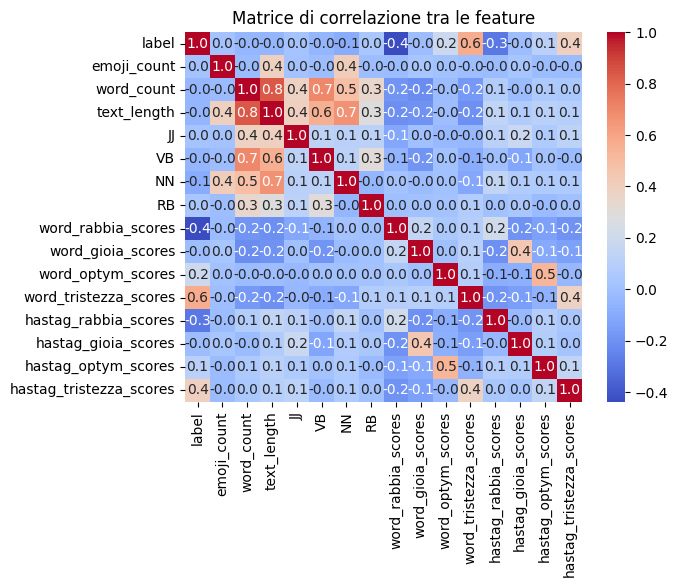

In [ ]:
sns.heatmap(data2.corr(), cmap="coolwarm", annot=True, fmt=".1f")
plt.title("Matrice di correlazione tra le feature")
plt.show()

In [ ]:
data2.drop("label", axis=1, inplace=True)
featureSel = SelectFromModel(estimator=RandomForestClassifier(n_estimators=200, n_jobs=-1), max_features=10)
data3 = featureSel.fit_transform(data2, labels)
print(f"Features tenute: {featureSel.get_feature_names_out()}")

Features tenute: ['word_rabbia_scores' 'word_gioia_scores' 'word_optym_scores'
 'word_tristezza_scores']


In [ ]:
#Ricreo il dataset finale con le feature estratte + il testo completo
data3 = pd.DataFrame(data3, columns=featureSel.get_feature_names_out())
data3.insert(0, "text", data["text"])
data3.insert(5, "label",labels)
data3

,text,word_rabbia_scores,word_gioia_scores,word_optym_scores,word_tristezza_scores,label
0,“Worry is a down payment on a problem you may ...,0.325949,0.043967,1.098025,0.310542,2
1,My roommate: it's okay that we can't spell bec...,0.783627,0.418665,0.030535,0.262310,0
2,No but that's so cute. Atsu was probably shy a...,0.210160,0.417779,0.073884,0.434790,1
3,Rooneys fucking untouchable isn't he? Been fuc...,1.085250,0.227798,0.013032,0.239959,0
4,it's pretty depressing when u hit pan on ur fa...,0.915637,0.286400,0.097587,0.923696,3
...,...,...,...,...,...,...
3252,I get discouraged because I try for 5 fucking ...,0.841893,0.383934,0.070561,0.594359,3
3253,The @user are in contention and hosting @user ...,1.121168,0.471898,0.157582,1.502535,3
3254,@user @user @user @user @user as a fellow UP g...,2.237947,0.869530,0.317996,0.852116,0
3255,You have a #problem? Yes! Can you do #somethin...,1.434666,0.477598,0.337615,0.775190,0


In [ ]:
#Train/test/val split 72/20/8
#(x_train, x_test, y_train, y_test) = train_test_split(data3[["text", "VB", "NN", "word_count", "important_word_count", "text_length"]], data3["label"], test_size=0.2, random_state=42)
#(x_train, x_val, y_train, y_val) = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
x_train = data3['text']
y_train = data3['label']
word_rabbia_scores = data3['word_rabbia_scores']
word_gioia_scores = data3['word_gioia_scores']
word_optym_scores = data3['word_optym_scores']
word_tristezza_scores = data3['word_tristezza_scores']

with open("/content/drive/MyDrive/NLP/Challenge_2024/emotion/val_text.txt", 'r', encoding='utf-8') as f:
    tweets = f.readlines()

# Rimuovi eventuali spazi vuoti o newline
tweets = [tweet.strip() for tweet in tweets]
val_text_df = pd.DataFrame(tweets, columns=['text'])

with open("/content/drive/MyDrive/NLP/Challenge_2024/emotion/val_labels.txt", 'r', encoding='utf-8') as f:
    labels = f.readlines()

labels2 = [int(label.strip()) for label in labels]

val_data = pd.DataFrame(tweets, columns=['text'])
val_data['label'] = labels2
val_data

,text,label
0,"@user @user Oh, hidden revenge and anger...I r...",0
1,if not then #teamchristine bc all tana has don...,0
2,Hey @user #Fields in #skibbereen give your onl...,0
3,Why have #Emmerdale had to rob #robron of havi...,0
4,@user I would like to hear a podcast of you go...,0
...,...,...
369,@user @user If #trump #whitehouse aren't held ...,0
370,@user Which #chutiya #producer #invested in #c...,0
371,Russia story will infuriate Trump today. Media...,0
372,Shit getting me irritated 😠,0


In [ ]:
# Applicazione della funzione ai tweet e creazione delle feature
tweet_vectors = []
for _, row in val_data.iterrows():
    tweet_vector = get_tweet_vector(row['text'])
    tweet_vectors.append(tweet_vector)

# Convertilo in un DataFrame per visualizzare le feature
tweet_feature_data = pd.DataFrame(tweet_vectors, columns=['Rabbia', 'Gioia', 'Ottimismo', 'Tristezza'])
val_data['words_emotion_scores'] = tweet_feature_data.values.tolist()

val_data['word_rabbia_scores'] = [x[0] for x in val_data['words_emotion_scores']]
val_data['word_gioia_scores'] = [x[1] for x in val_data['words_emotion_scores']]
val_data['word_optym_scores'] = [x[2] for x in val_data['words_emotion_scores']]
val_data['word_tristezza_scores'] = [x[3] for x in val_data['words_emotion_scores']]
val_data = val_data.drop(columns=['words_emotion_scores'])
val_data


,text,label,word_rabbia_scores,word_gioia_scores,word_optym_scores,word_tristezza_scores
0,"@user @user Oh, hidden revenge and anger...I r...",0,1.943678,0.548343,0.172057,0.596777
1,if not then #teamchristine bc all tana has don...,0,0.766414,0.171025,0.038231,0.252339
2,Hey @user #Fields in #skibbereen give your onl...,0,1.237283,0.360172,0.067842,0.386917
3,Why have #Emmerdale had to rob #robron of havi...,0,0.670438,0.274011,0.168171,0.411174
4,@user I would like to hear a podcast of you go...,0,0.815853,0.307425,0.252713,0.411069
...,...,...,...,...,...,...
369,@user @user If #trump #whitehouse aren't held ...,0,1.168047,0.353843,0.140551,0.616122
370,@user Which #chutiya #producer #invested in #c...,0,1.014222,0.289843,0.075192,0.268635
371,Russia story will infuriate Trump today. Media...,0,0.868525,0.273791,0.084892,0.402344
372,Shit getting me irritated 😠,0,1.202898,0.000000,0.042254,0.084509


In [ ]:
x_val = val_data['text']
word_rabbia_scores_val = val_data['word_rabbia_scores']
word_gioia_scores_val = val_data['word_gioia_scores']
word_optym_scores_val = val_data['word_optym_scores']
word_tristezza_scores_val = val_data['word_tristezza_scores']
label_val = val_data['label']

In [ ]:
x_train = x_train.apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))
x_val = x_val.apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))

#RIPRENDI DA QUI

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, x, word_rabbia_scores, word_gioia_scores, word_optym_scores, word_tristezza_scores, y, stopwords):

        # x e y sono series di pandas
        tokens_litt = [nltk.word_tokenize(text, language='english')
         for text in list(x)]
        text_clean = []

        if stopwords:
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w.lower() for w in sentence if
                    not w.lower() in nltk.corpus.stopwords.words("english")]))
        else:
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w.lower() for w in sentence]))
            # ogni token è separato dall'altro con uno spazio

        self.texts = text_clean
        self.labels = [torch.tensor(label) for label in y]
        self.word_rabbia_scores = [torch.tensor(score) for score in word_rabbia_scores]
        self.word_gioia_scores = [torch.tensor(score) for score in word_gioia_scores]
        self.word_optym_scores = [torch.tensor(score) for score in word_optym_scores]
        self.word_tristezza_scores = [torch.tensor(score) for score in word_tristezza_scores]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        batch_texts = self.texts[idx]
        batch_labels = np.array(self.labels[idx])
        batch_word_rabbia_scores = np.array(self.word_rabbia_scores[idx])
        batch_word_gioia_scores = np.array(self.word_gioia_scores[idx])
        batch_word_optym_scores = np.array(self.word_optym_scores[idx])
        batch_word_tristezza_scores = np.array(self.word_tristezza_scores[idx])

        return batch_texts, batch_word_rabbia_scores, batch_word_gioia_scores, batch_word_optym_scores, batch_word_tristezza_scores, batch_labels

In [ ]:
#Iperparametri della rete
#Uso il modello bertweet-base
hyperparameters = {
    "epochs": 5,
    "learning_rate": 1e-5,
    "batch_size": 16,
    "dropout": 0.1,
    "stopwords": False,
    "language_model": "vinai/bertweet-base",
    "layers": 1,
    "h_dim": 768,
    "bilstm": True,
    "patience": 5,
    "min_delta": 0.01,
}

In [ ]:
#!pip install emoji
#Installo la libreria emoji per trasformare le emoji di un testo in caratteri

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
word_rabbia_scores_val = val_data['word_rabbia_scores']
word_gioia_scores_val = val_data['word_gioia_scores']
word_optym_scores_val = val_data['word_optym_scores']
word_tristezza_scores_val = val_data['word_tristezza_scores']

In [ ]:
#creo i dataset
train_dataset = Dataset(x_train, word_rabbia_scores, word_gioia_scores, word_optym_scores, word_tristezza_scores, y_train, hyperparameters["stopwords"])
val_dataset = Dataset(x_val, word_rabbia_scores_val, word_gioia_scores_val, word_optym_scores_val, word_tristezza_scores_val ,label_val, hyperparameters["stopwords"])

Tokenizing ... : 100%|██████████| 374/374 [00:00<00:00, 160362.88it/s]


In [ ]:
extra_features = 4

class ClassifierDeep(nn.Module):

    def __init__(self, labels, hdim, dropout, model_name):
        super(ClassifierDeep, self).__init__()
        config = AutoConfig.from_pretrained(model_name)
        self.lm_model = AutoModel.from_pretrained(model_name, config=config)
        self.classifier = nn.Sequential(
            nn.Linear(hdim + extra_features, hdim),
            nn.BatchNorm1d(hdim),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hdim, hdim),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hdim, labels),
            #nn.Softmax()
            )

    def forward(self, input_id_text, attention_mask, word_rabbia_scores, word_gioia_scores, word_optym_scores, word_tristezza_scores):

        output = self.lm_model(input_id_text, attention_mask).last_hidden_state
        output = output[:,0,:]
        output = torch.cat((output, word_rabbia_scores.unsqueeze(1), word_gioia_scores.unsqueeze(1), word_optym_scores.unsqueeze(1), word_tristezza_scores.unsqueeze(1)), dim=1)
        return self.classifier(output)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta              # valore minimo di decrescita della loss di validazione all'epoca corrente
                                                # per asserire che c'è un miglioramento della loss
        self.counter = 0                        # contatore delle epoche di pazienza
        self.early_stop = False                 # flag di early stop
        self.min_validation_loss = torch.inf    # valore corrente ottimo della loss di validazione

    def __call__(self, validation_loss):
        # chiamata in forma funzionale dell'oggetto di classe EarlySopping

        if (validation_loss + self.min_delta) >= self.min_validation_loss:  # la loss di validazione non decresce
            self.counter += 1                                               # incrementiamo il contatore delle epoche di pazienza
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stop!")
        else:                                               # c'è un miglioramento della loss:
            self.min_validation_loss = validation_loss      # consideriamo la loss corrente
                                                            # come nuova loss ottimale
            self.counter = 0                                # e azzeriamo il contatore di pazienza

In [ ]:
def train_loop(model, dataloader, tokenizer, loss, optimizer, device):
    model.train()

    epoch_acc = 0
    epoch_loss = 0

    for batch_texts, batch_word_rabbia_scores, batch_word_gioia_scores, batch_word_optym_scores, batch_word_tristezza_scores, batch_labels in tqdm(dataloader, desc='training set'):

        optimizer.zero_grad()

        tokens = tokenizer(list(batch_texts), add_special_tokens=True, return_tensors='pt', padding='max_length', max_length = 128, truncation=True)
        input_id_texts = tokens['input_ids'].squeeze(1).to(device)
        batch_word_rabbia_scores = batch_word_rabbia_scores.float().to(device)
        batch_word_gioia_scores = batch_word_gioia_scores.float().to(device)
        batch_word_optym_scores = batch_word_optym_scores.float().to(device)
        batch_word_tristezza_scores = batch_word_tristezza_scores.float().to(device)

        mask_texts = tokens['attention_mask'].squeeze(1).to(device)
        batch_labels = batch_labels.to(device)
        output = model(input_id_texts, mask_texts, batch_word_rabbia_scores, batch_word_gioia_scores, batch_word_optym_scores, batch_word_tristezza_scores).squeeze(1)

        # la loss è una CrossEntropyLoss, al suo interno ha
        # la logsoftmax + negative log likelihood loss
        batch_loss = loss(output, batch_labels)
        batch_loss.backward()
        optimizer.step()
        epoch_loss += batch_loss.item()

        # per calcolare l'accuracy devo generare le predizioni
        # applicando manualmente la logsoftmax
        #softmax = nn.LogSoftmax(dim=1)
        #epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()
        preds = output.argmax(dim=1)
        epoch_acc += (preds == batch_labels).sum().item()

        batch_labels = batch_labels.detach().cpu()
        input_id_texts = input_id_texts.detach().cpu()
        mask_texts = mask_texts.detach().cpu()
        batch_word_rabbia_scores = batch_word_rabbia_scores.detach().cpu()
        batch_word_gioia_scores = batch_word_gioia_scores.detach().cpu()
        batch_word_optym_scores = batch_word_optym_scores.detach().cpu()
        batch_word_tristezza_scores = batch_word_tristezza_scores.detach().cpu()

        output = output.detach().cpu()

    return epoch_loss / len(dataloader), epoch_acc

In [ ]:
def test_loop(model, dataloader, tokenizer, loss, device, scheduler):
    model.eval()

    epoch_acc = 0
    epoch_loss = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():

        for batch_texts, batch_word_rabbia_scores, batch_word_gioia_scores, batch_word_optym_scores, batch_word_tristezza_scores, batch_labels in tqdm(dataloader, desc='dev set'):

            tokens = tokenizer(list(batch_texts), add_special_tokens=True, return_tensors='pt', padding='max_length', max_length = 128, truncation=True)
            input_id_texts = tokens['input_ids'].squeeze(1).to(device)
            batch_word_rabbia_scores = batch_word_rabbia_scores.float().to(device)
            batch_word_gioia_scores = batch_word_gioia_scores.float().to(device)
            batch_word_optym_scores = batch_word_optym_scores.float().to(device)
            batch_word_tristezza_scores = batch_word_tristezza_scores.float().to(device)

            mask_texts = tokens['attention_mask'].squeeze(1).to(device)
            batch_labels = batch_labels.to(device)
            output = model(input_id_texts, mask_texts, batch_word_rabbia_scores, batch_word_gioia_scores, batch_word_optym_scores, batch_word_tristezza_scores).squeeze(1)

            # la loss è una CrossEntropyLoss, al suo interno ha
            # la logsoftmax + negative log likelihood loss
            batch_loss = loss(output, batch_labels)
            epoch_loss += batch_loss.item()

            # per calcolare l'accuracy devo generare le predizioni
            # applicando manualmente la logsoftmax
            #softmax = nn.LogSoftmax(dim=1)
            #preds = softmax(output).argmax(dim=1)
            #epoch_acc += (preds == batch_labels).sum().item()
            preds = output.argmax(dim=1)
            epoch_acc += (preds == batch_labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

            batch_labels = batch_labels.detach().cpu()
            input_id_texts = input_id_texts.detach().cpu()
            mask_texts = mask_texts.detach().cpu()
            batch_word_rabbia_scores = batch_word_rabbia_scores.detach().cpu()
            batch_word_gioia_scores = batch_word_gioia_scores.detach().cpu()
            batch_word_optym_scores = batch_word_optym_scores.detach().cpu()
            batch_word_tristezza_scores = batch_word_tristezza_scores.detach().cpu()

            output = output.detach().cpu()
    scheduler.step(epoch_loss)
    f1 = f1_score(all_labels, all_preds, average="macro")

    return epoch_loss / len(dataloader), epoch_acc, f1

In [ ]:
def train_test(model, epochs, optimizer, device, train_data,
               batch_size, model_name, train_loss_fn,
               test_loss_fn=None,         # non necessariamente train e test loss devono differire
               early_stopping=None,       # posso addstrare senza early stopping
               val_data=None,             # e in questo caso non c'è validation set
               scheduler=None):           # possibile scheduler per monitorare l'andamento di un iperparametro,
                                          # tipicamente il learning rate

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    #test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    # check sulle funzioni di loss
    if test_loss_fn == None:
        test_loss_fn = train_loss_fn

    # liste dei valori di loss e accuracy epoca per epoca per il plot
    train_loss = []
    validation_loss = []
    test_loss = []

    train_acc = []
    validation_acc = []
    test_acc = []

    preds = []

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    #tokenizer = DebertaV2Tokenizer.from_pretrained(model_name)

    # Ciclo di addestramento con early stopping
    for epoch in tqdm(range(1,epochs+1)):

        epoch_train_loss, epoch_train_acc = train_loop(model, train_dataloader, tokenizer, train_loss_fn, optimizer, device)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc/len(train_data))

        # validation se è presente la callback di early stopping
        if early_stopping != None:
                epoch_validate_loss, epoch_validate_acc, f1 = test_loop(model, val_dataloader, tokenizer, test_loss_fn, device, scheduler)
                validation_loss.append(epoch_validate_loss)
                validation_acc.append(epoch_validate_acc/len(val_data))

        # test
        #epoch_test_loss, epoch_test_acc, f1 = test_loop(model, test_dataloader, tokenizer, test_loss_fn, device)
        #test_loss.append(epoch_test_loss)
        #test_acc.append(epoch_test_acc/len(test_data))

        val_loss_str = f'Validation loss: {epoch_validate_loss:6.4f} 'if early_stopping != None else ' '
        val_acc_str = f'Validation accuracy: {(epoch_validate_acc/len(val_data)):6.4f} ' if early_stopping != None else ' '
        print(f"\nF1 score: {f1:.4f}")
        print(f"\nTrain loss: {epoch_train_loss:6.4f} ---- {val_loss_str}")
        print(f"Train accuracy: {(epoch_train_acc/len(train_data)):6.4f} ---- {val_acc_str}")

        # early stopping
        if early_stopping != None:
                early_stopping(epoch_validate_loss)
                if early_stopping.early_stop:
                    break

    return train_loss, validation_loss, train_acc, validation_acc, f1

In [ ]:
#GRID SEARCH PER TROVARE I PARAMETRI MIGLIORI
param_grid = {
    "epochs":[20],
    "learning_rate": [1e-3],
    "batch_size": [32],
    "dropout": [0.2],
    "weight_decay": [0.0001]
}

best_f1 = 0
best_train_loss = 0
best_val_loss = 0
best_train_acc = 0
best_val_acc = 0
best_params={}
f1_value=0

grid = ParameterGrid(param_grid)
for params in grid:
  print("----------------------------------------------------------------")
  print(params)
  # Acquisiamo il device su cui effettueremo il training
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Using {device} device")

  model = ClassifierDeep(numLabels,
                      hyperparameters["h_dim"],
                      params["dropout"],
                      hyperparameters["language_model"]).to(device)

  print(model)

  # Calcoliamo il numero totale dei parametri del modello
  total_params = sum(p.numel() for p in model.parameters())
  print(f"Numero totale dei parametri: {total_params}")

  criterion = nn.CrossEntropyLoss()
  optimizer = AdamW(model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])
  scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer, start_factor=1, end_factor=0.1, total_iters=5)

  # Creiamo la callback di early stopping da passare al nostro metodo di addestramento
  early_stopping = EarlyStopping(patience=hyperparameters['patience'], min_delta=hyperparameters['min_delta'])




  train_loss, validation_loss, train_acc, validation_acc, f1_value = train_test(model,
                                                                                params['epochs'],
                                                                                optimizer, device, train_dataset,
                                                                                params['batch_size'], hyperparameters['language_model'],
                                                                                criterion, criterion, early_stopping,val_dataset, scheduler=scheduler)

  if f1_value > best_f1:
    best_f1 = f1_value
    best_params = copy.deepcopy(params)
    best_train_loss = train_loss
    best_val_loss = validation_loss
    best_train_acc = train_acc
    best_val_acc = validation_acc

torch.cuda.empty_cache()

----------------------------------------------------------------
{'batch_size': 32, 'dropout': 0.2, 'epochs': 20, 'learning_rate': 0.001, 'weight_decay': 0.0001}
Using cuda device
ClassifierDeep(
  (lm_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
training set: 100%|██████████| 102/102 [01:08<00:00,  1.48it/s]

  5%|▌         | 1/20 [01:11<22:34, 71.30s/it]


F1 score: 0.4996

Train loss: 0.6592 ---- Validation loss: 1.1241 
Train accuracy: 0.7590 ---- Validation accuracy: 0.5535 



training set: 100%|██████████| 102/102 [01:07<00:00,  1.50it/s]

 10%|█         | 2/20 [02:21<21:13, 70.75s/it]


F1 score: 0.5385

Train loss: 0.4601 ---- Validation loss: 1.0455 
Train accuracy: 0.8327 ---- Validation accuracy: 0.5963 



training set: 100%|██████████| 102/102 [01:07<00:00,  1.51it/s]

 15%|█▌        | 3/20 [03:31<19:56, 70.40s/it]


F1 score: 0.5314

Train loss: 0.4089 ---- Validation loss: 1.0316 
Train accuracy: 0.8508 ---- Validation accuracy: 0.5963 



training set: 100%|██████████| 102/102 [01:07<00:00,  1.51it/s]

 20%|██        | 4/20 [04:41<18:44, 70.30s/it]


F1 score: 0.5137

Train loss: 0.3714 ---- Validation loss: 1.0454 
Train accuracy: 0.8606 ---- Validation accuracy: 0.5749 



training set: 100%|██████████| 102/102 [01:08<00:00,  1.49it/s]

 25%|██▌       | 5/20 [05:52<17:37, 70.47s/it]


F1 score: 0.5357

Train loss: 0.3815 ---- Validation loss: 1.0253 
Train accuracy: 0.8597 ---- Validation accuracy: 0.6043 



training set: 100%|██████████| 102/102 [01:07<00:00,  1.51it/s]

 30%|███       | 6/20 [07:02<16:25, 70.37s/it]


F1 score: 0.5283

Train loss: 0.3589 ---- Validation loss: 1.0440 
Train accuracy: 0.8784 ---- Validation accuracy: 0.5882 



training set: 100%|██████████| 102/102 [01:07<00:00,  1.51it/s]

 35%|███▌      | 7/20 [08:12<15:12, 70.22s/it]


F1 score: 0.5222

Train loss: 0.3411 ---- Validation loss: 1.0584 
Train accuracy: 0.8772 ---- Validation accuracy: 0.5909 



training set: 100%|██████████| 102/102 [01:07<00:00,  1.51it/s]

 35%|███▌      | 7/20 [09:22<17:24, 80.38s/it]



F1 score: 0.5337

Train loss: 0.3490 ---- Validation loss: 1.0491 
Train accuracy: 0.8741 ---- Validation accuracy: 0.5989 
Early stop!


In [ ]:
print("Parametri best F1:\n")
print(f"F1 score: {best_f1:.4f}\n")
print(f"Iperparametri migliori: {params}\n")

Parametri best F1:

F1 score: 0.5337

Iperparametri migliori: {'batch_size': 32, 'dropout': 0.2, 'epochs': 20, 'learning_rate': 0.001, 'weight_decay': 0.0001}



(0.0, 1.0)

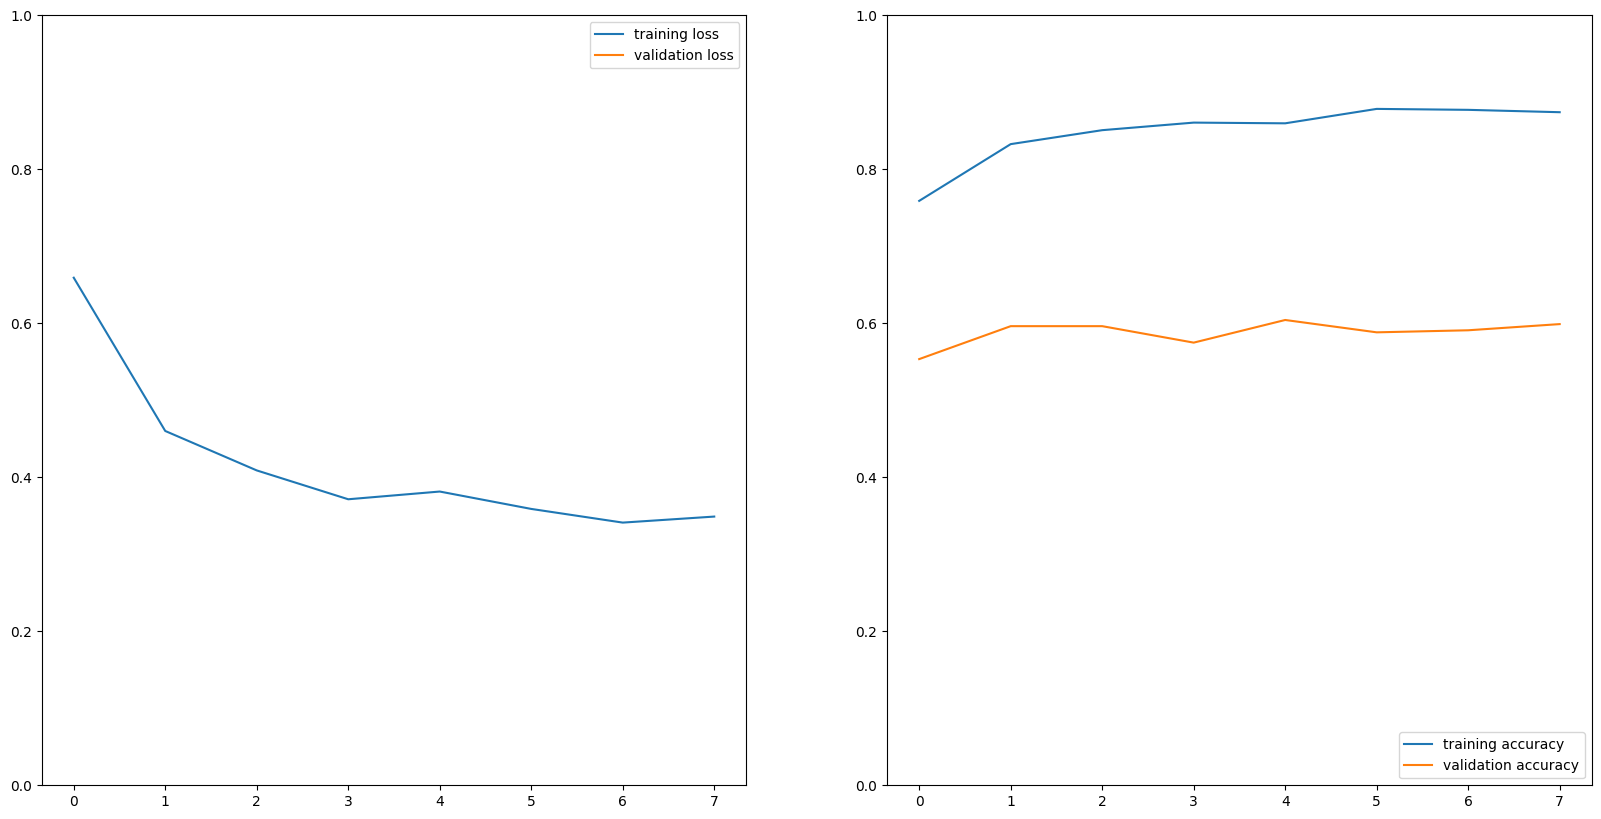

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].plot(best_train_loss, label='training loss')
axs[0].plot(best_val_loss, label='validation loss')
axs[0].legend(loc='upper right')
axs[0].set_ylim(0,1)

axs[1].plot(best_train_acc, label='training accuracy')
axs[1].plot(best_val_acc, label='validation accuracy')
axs[1].legend(loc='lower right')
axs[1].set_ylim(0,1)

In [ ]:
torch.save(model, "modello_completo.pth")


In [ ]:
torch.save(model.state_dict(), "modello_pesi.pth")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("/content/modello_completo.pth")  # Assicurati di caricare il modello
model.to(device)
model.eval()

# Carica il tokenizer
tokenizer = AutoTokenizer.from_pretrained(hyperparameters['language_model'])

# Carica i tweet di test
with open("/content/drive/MyDrive/NLP/Challenge_2024/emotion/test_text.txt", "r", encoding="utf-8") as f:
    test_tweets = [line.strip() for line in f.readlines()]

# Tokenizzazione
tokens = tokenizer(test_tweets, add_special_tokens=True, return_tensors="pt", padding=True, truncation=True, max_length=128)
input_id_texts = tokens["input_ids"].to(device)
mask_texts = tokens["attention_mask"].to(device)

# Crea tensori placeholder per le feature extra (rabbia, gioia, ottimismo, tristezza)
batch_word_rabbia_scores = torch.zeros(len(test_tweets), device=device)
batch_word_gioia_scores = torch.zeros(len(test_tweets), device=device)
batch_word_optym_scores = torch.zeros(len(test_tweets), device=device)
batch_word_tristezza_scores = torch.zeros(len(test_tweets), device=device)

with torch.no_grad():
    output = model(input_id_texts, mask_texts, batch_word_rabbia_scores, batch_word_gioia_scores, batch_word_optym_scores, batch_word_tristezza_scores)
    predictions = torch.argmax(torch.softmax(output, dim=1), dim=1).cpu().numpy()  # Softmax prima di argmax


<ipython-input-101-5536c6d6e77a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/content/modello_completo.pth")  # Assicurati di caricare il modello


In [ ]:
# Carica il modello addestrato
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# Carica il tokenizer
tokenizer = AutoTokenizer.from_pretrained(hyperparameters['language_model'])

with open("/content/drive/MyDrive/NLP/Challenge_2024/emotion/test_text.txt", "r", encoding="utf-8") as f:
    test_tweets = [line.strip() for line in f.readlines()]

tokens = tokenizer(test_tweets, add_special_tokens=True, return_tensors="pt", padding="max_length", max_length=128, truncation=True)
input_id_texts = tokens["input_ids"].to(device)
mask_texts = tokens["attention_mask"].to(device)

# Crea tensori placeholder per le feature extra (rabbia, gioia, ottimismo, tristezza)
batch_word_rabbia_scores = torch.zeros(len(test_tweets), device=device)
batch_word_gioia_scores = torch.zeros(len(test_tweets), device=device)
batch_word_optym_scores = torch.zeros(len(test_tweets), device=device)
batch_word_tristezza_scores = torch.zeros(len(test_tweets), device=device)

with torch.no_grad():
    output = model(input_id_texts, mask_texts, batch_word_rabbia_scores, batch_word_gioia_scores, batch_word_optym_scores, batch_word_tristezza_scores)
    predictions = torch.argmax(output, dim=1).cpu().numpy()  # Prendi la classe con la probabilità più alta


In [ ]:
predictions = model(test_tweets)

TypeError: ClassifierDeep.forward() missing 5 required positional arguments: 'attention_mask', 'word_rabbia_scores', 'word_gioia_scores', 'word_optym_scores', and 'word_tristezza_scores'